In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score , f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm, skew
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report,roc_curve,confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

In [68]:
df_train= pd.read_csv("Train.csv")
df_train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 8 columns):
Product          2452 non-null object
Product_Brand    2452 non-null object
Item_Category    2452 non-null object
Subcategory_1    2452 non-null object
Subcategory_2    2452 non-null object
Item_Rating      2452 non-null float64
Date             2452 non-null object
Selling_Price    2452 non-null float64
dtypes: float64(2), object(6)
memory usage: 153.3+ KB


In [70]:
df_train.describe()

,Item_Rating,Selling_Price
count,2452.000000,2452.000000
mean,3.078467,2494.375612
std,1.187137,7115.256516
min,1.000000,33.000000
25%,2.000000,371.000000
50%,3.100000,596.000000
75%,4.100000,1195.250000
max,5.000000,116289.000000


In [71]:
df_train.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
Selling_Price    0
dtype: int64

In [72]:
df_train["Product_Brand"].value_counts(ascending=False)[:20]

B-3078    688
B-133      91
B-2679     42
B-2372     40
B-1517     35
B-2307     35
B-2741     30
B-405      20
B-2355     16
B-3231     16
B-3197     14
B-2373     13
B-378      11
B-2895     10
B-2281      9
B-2201      9
B-3215      8
B-2370      7
B-1936      7
B-1260      7
Name: Product_Brand, dtype: int64

In [73]:
df_test= pd.read_csv("Test.csv")
df_test.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017


In [74]:
# processing date column
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month
df_test['year'] = df_test['Date'].dt.year
df_test['month'] = df_test['Date'].dt.month
df_train['day'] = df_train['Date'].dt.dayofweek
df_test['day'] = df_test['Date'].dt.dayofweek
df_train['year_rating'] = df_train['year'] + df_train['Item_Rating']
df_test['year_rating'] = df_test['year'] + df_test['Item_Rating']
df_train['month_rating'] = df_train['month'] + df_train['Item_Rating']
df_test['month_rating'] = df_test['month'] + df_test['Item_Rating']

In [75]:
df_train_encoded=df_train.copy()
df_train_encoded.tail()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,year,month,day,year_rating,month_rating
2447,P-8870,B-2292,clothing,kids clothing,girls wear,2.3,2017-11-03,741.0,2017,11,4,2019.3,13.3
2448,P-10672,B-3078,footwear,women s footwear,casual shoes,1.9,2016-04-12,1590.0,2016,4,1,2017.9,5.9
2449,P-2134,B-479,clothing,men s clothing,t shirts,1.9,2019-04-19,995.0,2019,4,4,2020.9,5.9
2450,P-724,B-133,automotive,accessories spare parts,car interior exterior,2.7,2014-01-12,1598.0,2014,1,6,2016.7,3.7
2451,P-1154,B-174,bags wallets belts,bags,pouches and potlis,4.1,2019-03-03,397.0,2019,3,6,2023.1,7.1


In [76]:
# Function to One HOt Encode the categorical columns
#columnsToEncode = list(df_train_encoded.select_dtypes(include=['category','object']))
#print(columnsToEncode)

#from sklearn.compose import ColumnTransformer
#columnTransformer = ColumnTransformer([('encoder',OneHotEncoder(),[0])],remainder='passthrough')
#data = np.array(columnTransformer.fit_transform(data), dtype = np.str)

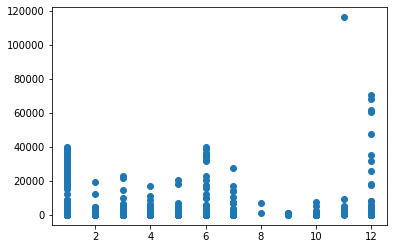

In [77]:
plt.scatter(df_train['month'],df_train['Selling_Price'])

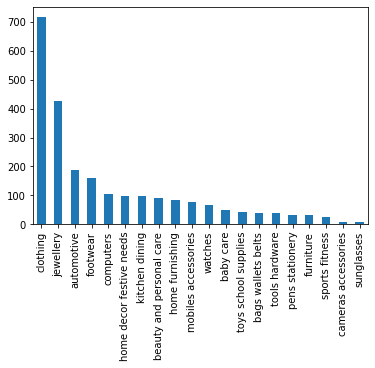

In [78]:
df_train['Item_Category'].value_counts()[:20].plot(kind='bar')

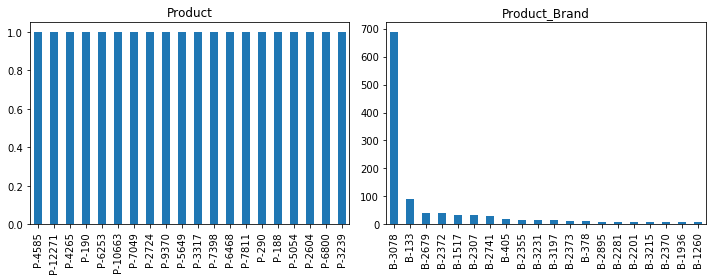

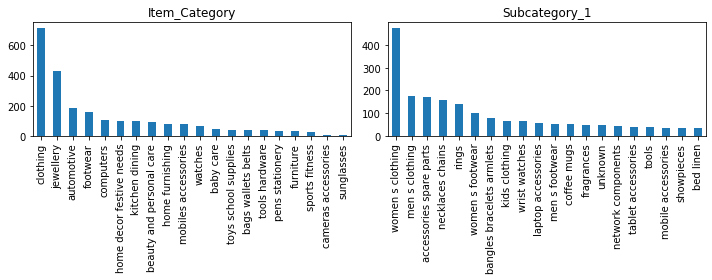

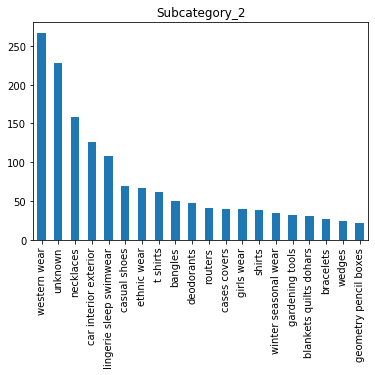

In [79]:
# Function to perform univariate analysis of categorical columns
def plot_categorical_columns(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object']).columns
    
    for i in range(0,len(categorical_columns),2):
            if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                dataframe[categorical_columns[i+1]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

            else:
                dataframe[categorical_columns[i]].value_counts()[:20].plot(kind='bar')
                plt.title(categorical_columns[i])
        
                
plot = plot_categorical_columns(df_train)

In [80]:
# Function to Label Encode the categorical columns
def dummyEncode(x):
    columnsToEncode = list(x.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            x[feature] = le.fit_transform(x[feature])
        except:
            print('Error encoding '+feature)
    return x
df_train_encoded = dummyEncode(df_train_encoded)
df_train_encoded.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,year,month,day,year_rating,month_rating
0,791,862,7,10,137,4.3,2017-02-03,291.0,2017,2,4,2021.3,6.3
1,760,670,10,127,329,3.1,2015-07-01,897.0,2015,7,2,2018.1,10.1
2,1746,280,29,112,101,3.5,2019-01-12,792.0,2019,1,5,2022.5,4.5
3,1214,670,8,37,134,4.0,2014-12-12,837.0,2014,12,4,2018.0,16.0
4,2104,670,10,80,296,4.3,2013-12-12,470.0,2013,12,3,2017.3,16.3


In [81]:
df_train_encoded.drop(['Selling_Price','Product','Date'],axis=1,inplace=True)
df_train_encoded.head()

,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,year,month,day,year_rating,month_rating
0,862,7,10,137,4.3,2017,2,4,2021.3,6.3
1,670,10,127,329,3.1,2015,7,2,2018.1,10.1
2,280,29,112,101,3.5,2019,1,5,2022.5,4.5
3,670,8,37,134,4.0,2014,12,4,2018.0,16.0
4,670,10,80,296,4.3,2013,12,3,2017.3,16.3


In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df_train_normalized=scaler.fit_transform(df_train_encoded)
df_train_normalized=pd.DataFrame(df_train_normalized, columns = df_train_encoded.columns)
df_train_normalized.head()

,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,year,month,day,year_rating,month_rating
0,0.854311,0.094595,0.077519,0.408955,0.825,0.625,0.090909,0.666667,0.691667,0.286667
1,0.664024,0.135135,0.984496,0.982090,0.525,0.375,0.545455,0.333333,0.425000,0.540000
2,0.277502,0.391892,0.868217,0.301493,0.625,0.875,0.000000,0.833333,0.791667,0.166667
3,0.664024,0.108108,0.286822,0.400000,0.750,0.250,1.000000,0.666667,0.416667,0.933333
4,0.664024,0.135135,0.620155,0.883582,0.825,0.125,1.000000,0.500000,0.358333,0.953333


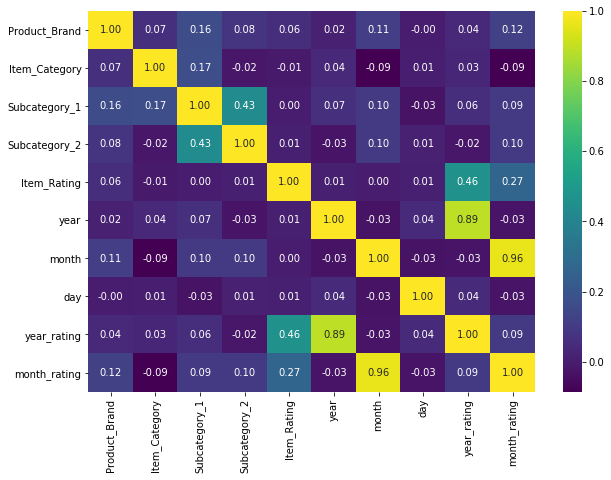

In [83]:
plt.figure(figsize=(10,7))
sns.heatmap(df_train_normalized.corr(), cmap='viridis',annot=True, fmt='.2f')

In [84]:
y=df_train['Selling_Price'].to_frame()
y=np.log(y)
X=df_train_normalized.copy()
print(y.shape)
print(X.shape)
print(y.head())

(2452, 1)
(2452, 10)
   Selling_Price
0       5.673323
1       6.799056
2       6.674561
3       6.729824
4       6.152733


In [85]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=0)
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_val)

In [86]:
print("Mean Squared Error: ",mean_squared_error(y_val,y_pred))
print("R2 Score: ",r2_score(y_val,y_pred))
print("Mean Absolute Error: ",mean_absolute_error(y_val,y_pred))
print("RMSE: ",np.sqrt(mean_squared_error(y_val,y_pred)))
print("RMSLE: ",np.sqrt(mean_squared_log_error( y_val,y_pred )))

Mean Squared Error:  1.1256195489479082
R2 Score:  0.07142368606891425
Mean Absolute Error:  0.7940201810279879
RMSE:  1.0609521897559324
RMSLE:  0.13125052024123632


In [87]:
import xgboost
xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
xgb_model.fit(X_train,y_train)

[21:09:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [88]:
y_pred_xgb = xgb_model.predict(X_val)

In [89]:
print("Mean Squared Error: ",mean_squared_error(y_val,y_pred_xgb))
print("R2 Score: ",r2_score(y_val,y_pred_xgb))
print("Mean Absolute Error: ",mean_absolute_error(y_val,y_pred_xgb))
print("RMSE: ",np.sqrt(mean_squared_error(y_val,y_pred_xgb)))
print("RMSLE: ",np.sqrt(mean_squared_log_error( y_val,y_pred_xgb )))

Mean Squared Error:  0.5001485505107363
R2 Score:  0.587404023068608
Mean Absolute Error:  0.5244155294437332
RMSE:  0.7072118144592441
RMSLE:  0.09368445749217798


In [90]:
my_pipeline = make_pipeline(RandomForestRegressor())
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_squared_log_error')
print(scores)

RMSLE=np.sqrt(scores)
print(RMSLE)

[-0.0094014  -0.00883102 -0.00785634 -0.00884625 -0.00749077]
[nan nan nan nan nan]


In [91]:
lasso =Lasso(alpha=0.1)
lasso.fit(X_train,y_train)
y_pred_lasso=lasso.predict(X_val)

In [92]:
print("Mean Squared Error: ",mean_squared_error(y_val,y_pred_lasso))
print("R2 Score: ",r2_score(y_val,y_pred_lasso))
print("Mean Absolute Error: ",mean_absolute_error(y_val,y_pred_lasso))
print("RMSE: ",np.sqrt(mean_squared_error(y_val,y_pred_lasso)))
print("RMSLE: ",np.sqrt(mean_squared_log_error( y_val,y_pred_lasso)))

Mean Squared Error:  1.2145838846366626
R2 Score:  -0.0019671634258420223
Mean Absolute Error:  0.7919740126552912
RMSE:  1.1020816143265717
RMSLE:  0.13458922862310996


In [93]:
en =ElasticNet(alpha=1)
en.fit(X_train,y_train)
y_pred_en=en.predict(X_val)

In [94]:
print("Mean Squared Error: ",mean_squared_error(y_val,y_pred_en))
print("R2 Score: ",r2_score(y_val,y_pred_en))
print("Mean Absolute Error: ",mean_absolute_error(y_val,y_pred_en))
print("RMSE: ",np.sqrt(mean_squared_error(y_val,y_pred_en)))
print("RMSLE: ",np.sqrt(mean_squared_log_error( y_val,y_pred_en)))

Mean Squared Error:  1.2145838846366626
R2 Score:  -0.0019671634258420223
Mean Absolute Error:  0.7919740126552912
RMSE:  1.1020816143265717
RMSLE:  0.13458922862310996


In [95]:
df_test_encoded=df_test.copy()
df_test_encoded.tail()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,year,month,day,year_rating,month_rating
1046,P-9758,B-2543,sports fitness,outdoor adventure,camping hiking,2.0,2014-02-28,2014,2,4,2016.0,4.0
1047,P-11898,B-3197,jewellery,necklaces chains,necklaces,4.7,2019-01-12,2019,1,5,2023.7,5.7
1048,P-904,B-133,automotive,accessories spare parts,car interior exterior,3.5,2014-01-12,2014,1,6,2017.5,4.5
1049,P-1714,B-358,kitchen dining,lighting,bulbs,2.4,2013-06-23,2013,6,6,2015.4,8.4
1050,P-620,B-133,automotive,accessories spare parts,car interior exterior,3.1,2012-01-12,2012,1,3,2015.1,4.1


In [96]:
df_test_encoded = dummyEncode(df_test_encoded)
df_test_encoded.head()
df_test_encoded.drop(['Product','Date'],1,inplace=True)

In [97]:
df_test_normalize=scaler.fit_transform(df_test_encoded)
df_test_normalized=pd.DataFrame(df_test_normalize, columns = df_test_encoded.columns)

In [98]:
df_test_normalized['Selling Price']= xgb_model.predict(df_test_normalized)
df_test_normalized.head()

,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,year,month,day,year_rating,month_rating,Selling Price
0,0.657201,0.282609,0.673913,0.704663,0.825,0.750,0.0,0.666667,0.775000,0.220000,7.114211
1,0.261663,0.586957,0.086957,0.145078,0.500,0.000,1.0,0.500000,0.166667,0.866667,6.029811
2,0.685598,0.260870,0.978261,0.989637,0.125,0.250,0.0,1.000000,0.208333,0.033333,7.578694
3,0.168357,0.586957,0.663043,0.590674,0.725,0.875,0.0,0.833333,0.825000,0.193333,6.211294
4,0.685598,0.260870,0.978261,0.989637,0.100,0.625,0.0,0.500000,0.450000,0.026667,7.499587


In [99]:
df_test['Selling_Price']=np.exp(df_test_normalized['Selling Price'])
df_test.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,year,month,day,year_rating,month_rating,Selling_Price
0,P-11284,B-2984,computers,network components,routers,4.3,2018-01-12,2018,1,4,2022.3,5.3,1229.312866
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,2012-12-20,2012,12,3,2015.0,15.0,415.636627
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,2014-01-12,2014,1,6,2015.5,2.5,1956.073364
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,2019-01-12,2019,1,5,2022.9,4.9,498.345795
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,2017-01-12,2017,1,3,2018.4,2.4,1807.295044


In [100]:
filename = 'Ecom_Sub.xlsx'
pd.DataFrame({'Selling_Price':df_test['Selling_Price']}).to_excel(filename, index=False)